In [1]:
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
import scipy.spatial
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from ERA5.ERA5_processor import era5_processing

In [2]:
def build_triangulation(x, y):
    """
    Creates a Delaunay tesselation
    
    """
    grid = np.stack([x, y], axis=1)
    return scipy.spatial.Delaunay(grid)

def interpolate(data, tri, mesh):
    """
    Interpolates the ERA5 grid using the Delaunay tesselation
    
    """
    indices = tri.find_simplex(mesh)
    ndim = tri.transform.shape[-1]
    T_inv = tri.transform[indices, :ndim, :]
    r = tri.transform[indices, ndim, :]
    c = np.einsum('...ij,...j', T_inv, mesh - r)
    c = np.concatenate([c, 1 - c.sum(axis=-1, keepdims=True)], axis=-1)
    result = np.einsum('...i,...i', data[:, tri.simplices[indices]], c)
    return np.where(indices == -1, np.nan, result)

def era5_processing(variable, year_start, year_end):
    
    # Test bucket access
    fs = fsspec.filesystem('gs')
    fs.ls('gs://gcp-public-data-arco-era5/co/')
    
    # Opening dataset with zarr
    reanalysis = xr.open_zarr(
        'gs://gcp-public-data-arco-era5/co/single-level-reanalysis.zarr', 
        chunks={'time': 48},
        consolidated=True,
        )
    
        # Dates
    i_date = str(year_start) + '-01-01'
    f_date = str(year_end)   + '-12-31'
    
    recent_an = reanalysis.sel(time=slice(i_date, f_date))

    era5_var = recent_an[variable]
    
    lon_min = 267.2
    lon_max = 274
    lat_min = 36
    lat_max = 43.5
    
    illinois_ds = recent_an.where(
    (recent_an.longitude > lon_min) & (recent_an.latitude > lat_min) &
    (recent_an.longitude < lon_max) & (recent_an.latitude < lat_max),
    drop=True)
    
    tri = build_triangulation(illinois_ds.longitude, illinois_ds.latitude)
    longitude = np.linspace(lon_min, lon_max, num=round(lon_max-lon_min)*4+1)
    latitude = np.linspace(lat_min, lat_max, num=round(lat_max-lat_min)*4+1)
    
    mesh = np.stack(np.meshgrid(longitude, latitude, indexing='ij'), axis=-1)
    mesh_int = interpolate(illinois_ds[variable].values, tri, mesh)
    fin_array = xr.DataArray(mesh_int, 
                             coords=[('time', illinois_ds.time.data), ('longitude', longitude), ('latitude', latitude)])
    fin_array = fin_array.rename({'longitude':'lon', 'latitude':'lat'})
    
    return fin_array


# Picking out the US for all variables and time frames

In [6]:
d = era5_processing('cape', 2004, 2004)

In [30]:
d

<xarray.DataArray (time: 8784, lon: 29, lat: 33)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan, 282.59489949, 282.36200759, ..., 267.24869611,
         266.99433878,          nan],
        [         nan, 282.39991073, 282.14462477, ..., 268.21742521,
         268.18664531,          nan],
        ...,
        [         nan, 280.85170795, 281.40597031, ..., 275.22585553,
         274.78400126,          nan],
        [         nan,          nan,          nan, ..., 274.78441436,
         273.59890705,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan, 282.4382258 , 282.12106557, ..., 267.21686019,
         267.03061933,          nan],
        [         nan, 282.29926242, 281.99637249, ..., 267.24568655,
         267.72486472,          nan],
...
        [         nan, 289.13939387, 289.02244411, ..., 279.40844921,
         278.88049327,          nan],
        [         nan,          nan,          nan, ..., 279.16439222,
         278.84885499,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan, 290.75624804, 290.58000305, ..., 269.87732408,
         268.95720356,          nan],
        [         nan, 290.57747631, 290.39850193, ..., 270.00304759,
         269.15317491,          nan],
        ...,
        [         nan, 288.90938628, 288.84365315, ..., 279.25100736,
         278.585311  ,          nan],
        [         nan,          nan,          nan, ..., 279.2077576 ,
         278.67531454,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2004-01-01 ... 2004-12-31T23:00:00
  * lon      (lon) float64 267.2 267.4 267.7 267.9 ... 273.3 273.5 273.8 274.0
  * lat      (lat) float64 36.0 36.23 36.47 36.7 36.94 ... 42.8 43.03 43.27 43.5

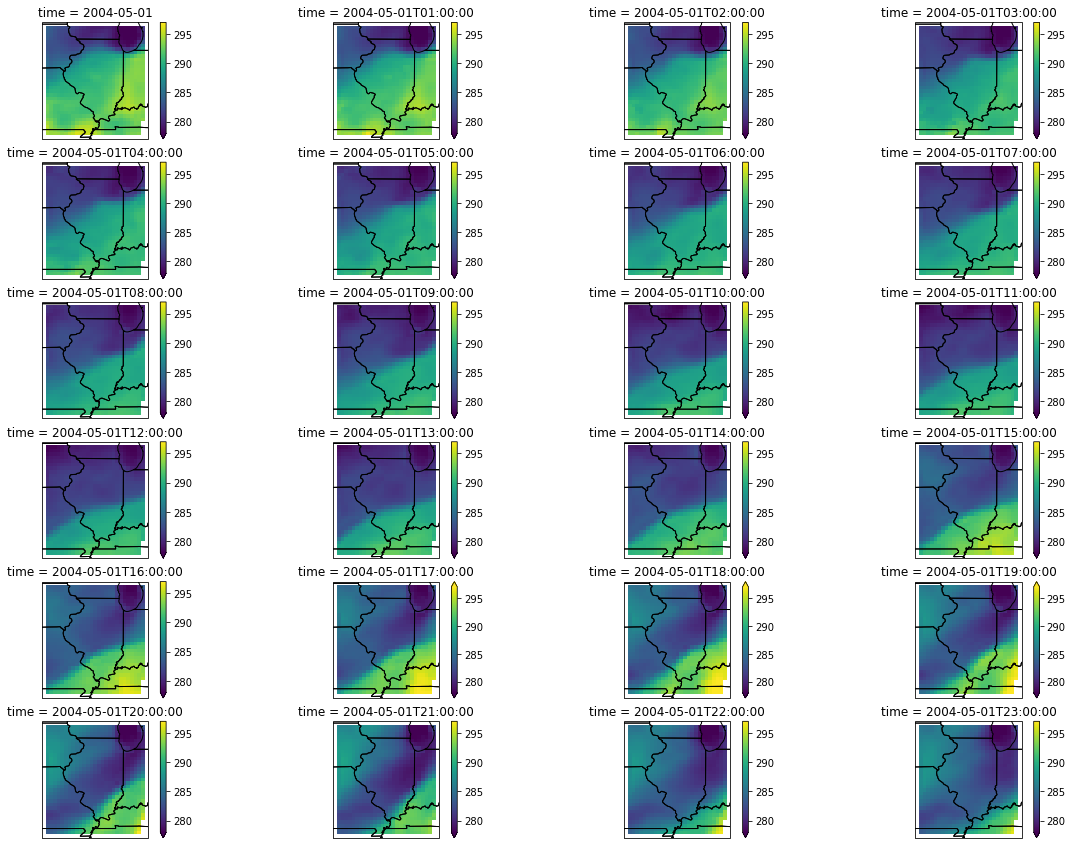

In [33]:
plt.rcParams['figure.figsize'] = [20, 15]
fig, ax = plt.subplots(6,4, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
ax = ax.flatten()

for time in range(0,24):
    if time < 10:
        time_str = '0' + str(time)
    else:
        time_str = time
    datetime = '2004-05-01T' + str(time_str)
    d.sel(time=datetime).plot.pcolormesh(x='lon', y='lat', ax=ax[time], transform=ccrs.PlateCarree(), vmin=278, vmax=297)
    ax[time].add_feature(cfeature.STATES)


In [14]:
# Test bucket access
fs = fsspec.filesystem('gs')
fs.ls('gs://gcp-public-data-arco-era5/co/')

# Opening dataset with zarr
reanalysis = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3', 
    chunks={'time': 48},
    consolidated=True,
    )

reanalysis_time = reanalysis.sel(time=slice('2023-01-01', '2023-12-31'))

era5_tp = reanalysis_time['total_precipitation']

lon_min = 267.2
lon_max = 274
lat_min = 36
lat_max = 43.5

illinois_tp = era5_tp.where(
(era5_tp.longitude > lon_min) & (era5_tp.latitude > lat_min) &
(era5_tp.longitude < lon_max) & (era5_tp.latitude < lat_max),
drop=True)
    
illinois_tp

<xarray.DataArray 'total_precipitation' (time: 8760, latitude: 29, longitude: 27)>
dask.array<where, shape=(8760, 29, 27), dtype=float32, chunksize=(48, 29, 27), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 43.25 43.0 42.75 42.5 ... 36.75 36.5 36.25
  * longitude  (longitude) float32 267.2 267.5 267.8 268.0 ... 273.2 273.5 273.8
  * time       (time) datetime64[ns] 2023-01-01 ... 2023-12-31T23:00:00
Attributes:
    long_name:   Total precipitation
    short_name:  tp
    units:       m

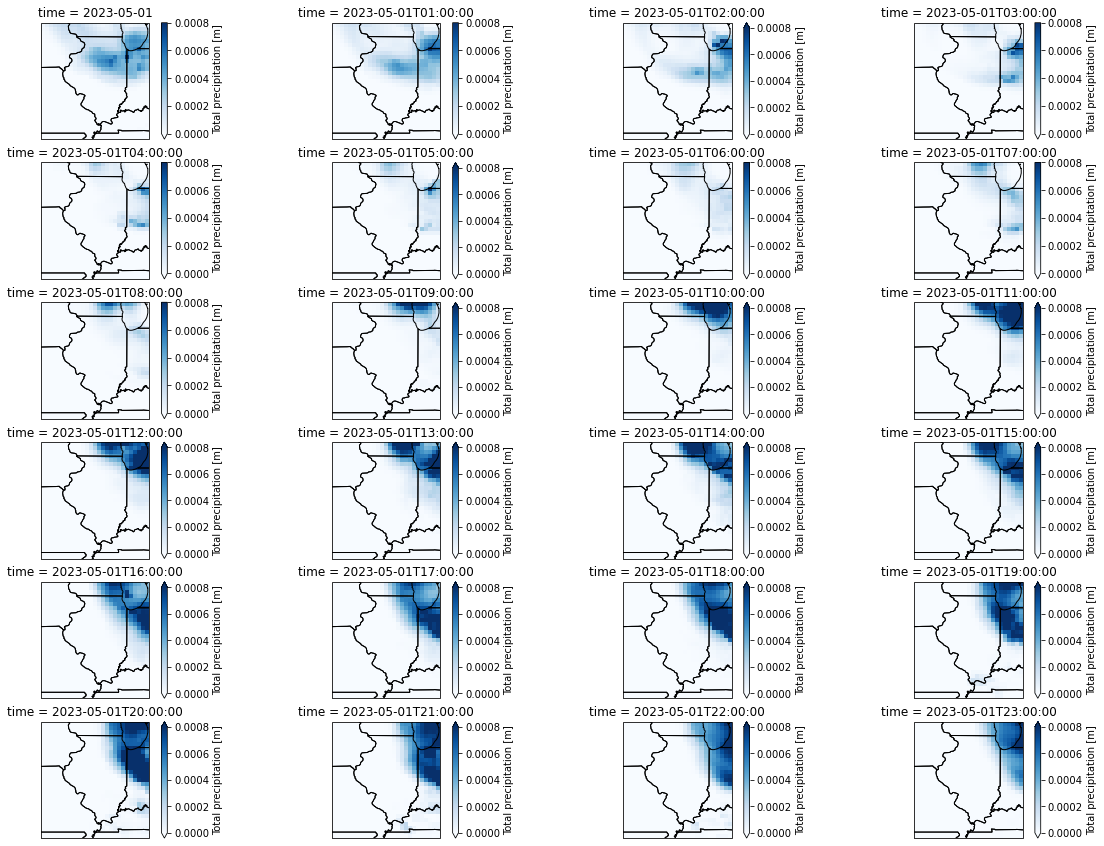

In [18]:
plt.rcParams['figure.figsize'] = [20, 15]
fig, ax = plt.subplots(6,4, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
ax = ax.flatten()

for time in range(0,24):
    if time < 10:
        time_str = '0' + str(time)
    else:
        time_str = time
    datetime = '2023-05-01T' + str(time_str)
    illinois_tp.sel(time=datetime).plot.pcolormesh(x='longitude', y='latitude', ax=ax[time], transform=ccrs.PlateCarree(), 
                                                   cmap='Blues', vmin=0, vmax=0.0008)
    ax[time].add_feature(cfeature.STATES)

In [20]:
# Test bucket access
fs = fsspec.filesystem('gs')
fs.ls('gs://gcp-public-data-arco-era5/co/')

# Opening dataset with zarr
reanalysis = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3', 
    chunks={'time': 48},
    consolidated=True,
    )

reanalysis_time = reanalysis.sel(time=slice('2004-01-01', '2004-12-31'))

era5_t2m = reanalysis_time['2m_temperature']

lon_min = 267.2
lon_max = 274
lat_min = 36
lat_max = 43.5

illinois_t2m = era5_t2m.where(
(era5_t2m.longitude > lon_min) & (era5_t2m.latitude > lat_min) &
(era5_t2m.longitude < lon_max) & (era5_t2m.latitude < lat_max),
drop=True)
    
illinois_t2m

<xarray.DataArray '2m_temperature' (time: 8784, latitude: 29, longitude: 27)>
dask.array<where, shape=(8784, 29, 27), dtype=float32, chunksize=(48, 29, 27), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 43.25 43.0 42.75 42.5 ... 36.75 36.5 36.25
  * longitude  (longitude) float32 267.2 267.5 267.8 268.0 ... 273.2 273.5 273.8
  * time       (time) datetime64[ns] 2004-01-01 ... 2004-12-31T23:00:00
Attributes:
    long_name:   2 metre temperature
    short_name:  t2m
    units:       K

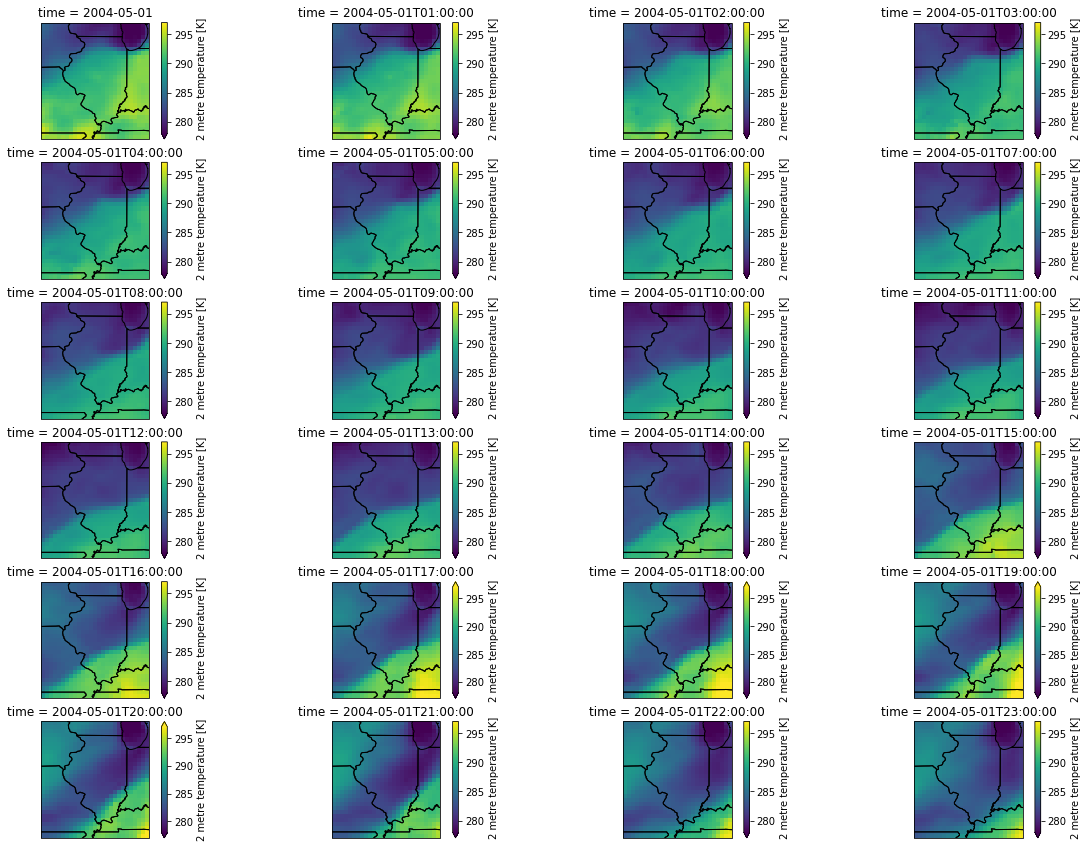

In [22]:
plt.rcParams['figure.figsize'] = [20, 15]
fig, ax = plt.subplots(6,4, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
ax = ax.flatten()

for time in range(0,24):
    if time < 10:
        time_str = '0' + str(time)
    else:
        time_str = time
    datetime = '2004-05-01T' + str(time_str)
    illinois_t2m.sel(time=datetime).plot.pcolormesh(x='longitude', y='latitude', ax=ax[time], transform=ccrs.PlateCarree(),
                                                    vmin=278, vmax=297)
    ax[time].add_feature(cfeature.STATES)

# Testing multiple variables

In [2]:
import fsspec
import xarray as xr
import scipy.spatial
import numpy as np
import os
import argparse
from datetime import date
from calculations.calculations import vapor_pressure
from calculations.calculations import wind_tot
import metpy
from metpy.units import units 


# Using code from https://github.com/google-research/arco-era5/blob/main/docs/0-Surface-Reanalysis-Walkthrough.ipynb 

def build_triangulation(x, y):
    """
    Creates a Delaunay tesselation
    
    """
    grid = np.stack([x, y], axis=1)
    return scipy.spatial.Delaunay(grid)

def interpolate(data, tri, mesh):
    """
    Interpolates the ERA5 grid using the Delaunay tesselation
    
    """
    indices = tri.find_simplex(mesh)
    ndim = tri.transform.shape[-1]
    T_inv = tri.transform[indices, :ndim, :]
    r = tri.transform[indices, ndim, :]
    c = np.einsum('...ij,...j', T_inv, mesh - r)
    c = np.concatenate([c, 1 - c.sum(axis=-1, keepdims=True)], axis=-1)
    result = np.einsum('...i,...i', data[:, tri.simplices[indices]], c)
    return np.where(indices == -1, np.nan, result)

def era5_processing(variable, i_date, f_date, dataset):
    """
    Code to process ERA5 Data over the state of Illinois
    https://github.com/google-research/arco-era5 
    
    Inputs:
        - variable (str) - Variable name to call, using ERA5 data names
                           User can also call "vapor_pressure" (mb), "sfcWind" (m/s) and "relative_humidity" (decimal)
        - year_start (int) - First year you'd like to request
        - year_end (int) - Last year you'd like to request (inclusive)
        - dataset (str) - Either use the "raw" or "analysis_ready" dataset from ARCO-ERA5 (for specifics, see 
                            Github link)
    Outputs:
        - fin_array (Dataarray) - Dataarray with appropriate ERA5 data for the variable and timeframe chosen,
                                   interpolated using Delaunay triangulation
        
    """
    # Test bucket access
    fs = fsspec.filesystem('gs')
    fs.ls('gs://gcp-public-data-arco-era5/co/')

    calc = []
    # Pulling appropriate variables for calculations        
    if 'vapor_pressure' in variable:
        variable.append('2m_dewpoint_temperature')
        variable.remove('vapor_pressure')
        calc.append('vapor_pressure')
    if 'sfcWind' in variable:
        variable.append('10m_u_component_of_wind')
        variable.append('10m_v_component_of_wind')
        variable.remove('sfcWind')
        calc.append('sfcWind')
    if 'relative_humidity' in variable:
        variable.append('2m_temperature')
        variable.append('2m_dewpoint_temperature')
        variable.remove('relative_humidity')
        calc.append('relative_humidity')
    print(variable)

        

    if dataset == 'raw':
        # Opening dataset with zarr
        reanalysis = xr.open_zarr(
            'gs://gcp-public-data-arco-era5/co/single-level-reanalysis.zarr', 
            chunks={'time': 48},
            consolidated=True,
            )
    
    if dataset == 'analysis_ready':
        # Opening dataset with zarr
        reanalysis = xr.open_zarr(
            'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3', 
            chunks={'time': 48},
            consolidated=True,
            )
        print('Done')

    
    recent_an = reanalysis.sel(time=slice(i_date, f_date))

    era5_var = recent_an[variable]
    
    lon_min = 267.2
    lon_max = 274
    lat_min = 36
    lat_max = 43.5
    
    illinois_ds = era5_var.where(
    (recent_an.longitude > lon_min) & (recent_an.latitude > lat_min) &
    (recent_an.longitude < lon_max) & (recent_an.latitude < lat_max),
    drop=True)
    
    if dataset == 'raw':
        tri = build_triangulation(illinois_ds.longitude, illinois_ds.latitude)
        longitude = np.linspace(lon_min, lon_max, num=round(lon_max-lon_min)*4+1)
        latitude = np.linspace(lat_min, lat_max, num=round(lat_max-lat_min)*4+1)
            
        mesh = np.stack(np.meshgrid(longitude, latitude, indexing='ij'), axis=-1)
        mesh_int = interpolate(illinois_ds[variable].values, tri, mesh)
        
        fin_array = xr.DataArray(mesh_int, 
                             coords=[('time', illinois_ds.time.data), ('longitude', longitude), ('latitude', latitude)])
    else:
        fin_array = illinois_ds
        
    fin_array = fin_array.rename({'longitude':'lon', 'latitude':'lat'})
    print(fin_array)
    
    # Calculations
    if 'vapor_pressure' in calc:
        fin_array['vapor_pressure'] = vapor_pressure(fin_array['2m_dewpoint_temperature']) # Calculation
    if 'sfcWind' in calc:
        fin_array['sfcWind'],_ = wind_tot(fin_array['10m_u_component_of_wind'], fin_array['10m_v_component_of_wind'])
    if 'relative_humidity' in calc:
         rh = metpy.calc.relative_humidity_from_dewpoint(
                                        fin_array['2m_temperature'] * units.K,
                                        fin_array['2m_dewpoint_temperature'] * units.K)
         fin_array['relative_humidity'] = rh.metpy.dequantify()
    
    return fin_array

In [4]:
era5_processing('t2m', '2014-10-20', '2014-10-30, 'raw')

t2m


KeyError: "No variable named 't2m'. Variables on the dataset include ['100m_u_component_of_wind', '100m_v_component_of_wind', '10m_u_component_of_neutral_wind', '10m_u_component_of_wind', '10m_v_component_of_neutral_wind', ..., 'wave_spectral_directional_width_for_wind_waves', 'wave_spectral_kurtosis', 'wave_spectral_peakedness', 'wave_spectral_skewness', 'zero_degree_level']"

In [3]:
variables = [
    "2m_temperature",
    "2m_dewpoint_temperature",
    "10m_u_component_of_wind",
    "10m_v_component_of_wind",
    "vapor_pressure",
    "sfcWind",
    "relative_humidity",
]

 
test_dset = era5_processing(variables, '2014-10-20', '2014-10-30', 'analysis_ready')
test_dset

['2m_temperature', '2m_dewpoint_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_temperature', '2m_dewpoint_temperature']
Done
<xarray.Dataset> Size: 3MB
Dimensions:                  (time: 264, lat: 29, lon: 27)
Coordinates:
  * lat                      (lat) float32 116B 43.25 43.0 42.75 ... 36.5 36.25
  * lon                      (lon) float32 108B 267.2 267.5 ... 273.5 273.8
  * time                     (time) datetime64[ns] 2kB 2014-10-20 ... 2014-10...
Data variables:
    2m_temperature           (time, lat, lon) float32 827kB dask.array<chunksize=(48, 29, 27), meta=np.ndarray>
    2m_dewpoint_temperature  (time, lat, lon) float32 827kB dask.array<chunksize=(48, 29, 27), meta=np.ndarray>
    10m_u_component_of_wind  (time, lat, lon) float32 827kB dask.array<chunksize=(48, 29, 27), meta=np.ndarray>
    10m_v_component_of_wind  (time, lat, lon) float32 827kB dask.array<chunksize=

<xarray.Dataset> Size: 6MB
Dimensions:                  (time: 264, lat: 29, lon: 27)
Coordinates:
  * lat                      (lat) float32 116B 43.25 43.0 42.75 ... 36.5 36.25
  * lon                      (lon) float32 108B 267.2 267.5 ... 273.5 273.8
  * time                     (time) datetime64[ns] 2kB 2014-10-20 ... 2014-10...
Data variables:
    2m_temperature           (time, lat, lon) float32 827kB dask.array<chunksize=(48, 29, 27), meta=np.ndarray>
    2m_dewpoint_temperature  (time, lat, lon) float32 827kB dask.array<chunksize=(48, 29, 27), meta=np.ndarray>
    10m_u_component_of_wind  (time, lat, lon) float32 827kB dask.array<chunksize=(48, 29, 27), meta=np.ndarray>
    10m_v_component_of_wind  (time, lat, lon) float32 827kB dask.array<chunksize=(48, 29, 27), meta=np.ndarray>
    vapor_pressure           (time, lat, lon) float32 827kB dask.array<chunksize=(48, 29, 27), meta=np.ndarray>
    sfcWind                  (time, lat, lon) float32 827kB dask.array<chunksize=(48, 29, 27), meta=np.ndarray>
    relative_humidity        (time, lat, lon) float32 827kB dask.array<chunksize=(48, 29, 27), meta=np.ndarray>
Attributes:
    last_updated:           2025-04-24 02:36:27.322824+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-01-31
    valid_time_stop_era5t:  2025-04-18

In [4]:
test_dset.load()

<xarray.Dataset> Size: 6MB
Dimensions:                  (time: 264, lat: 29, lon: 27)
Coordinates:
  * lat                      (lat) float32 116B 43.25 43.0 42.75 ... 36.5 36.25
  * lon                      (lon) float32 108B 267.2 267.5 ... 273.5 273.8
  * time                     (time) datetime64[ns] 2kB 2014-10-20 ... 2014-10...
Data variables:
    2m_temperature           (time, lat, lon) float32 827kB 288.5 ... 285.7
    2m_dewpoint_temperature  (time, lat, lon) float32 827kB 281.6 ... 278.3
    10m_u_component_of_wind  (time, lat, lon) float32 827kB 3.525 ... 0.04622
    10m_v_component_of_wind  (time, lat, lon) float32 827kB 2.487 ... -1.389
    vapor_pressure           (time, lat, lon) float32 827kB 11.05 11.0 ... 8.847
    sfcWind                  (time, lat, lon) float32 827kB 4.314 4.449 ... 1.39
    relative_humidity        (time, lat, lon) float32 827kB 0.6341 ... 0.6069
Attributes:
    last_updated:           2025-04-24 02:36:27.322824+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-01-31
    valid_time_stop_era5t:  2025-04-18

In [5]:
test_dset.mean('time')

<xarray.Dataset> Size: 22kB
Dimensions:                  (lat: 29, lon: 27)
Coordinates:
  * lat                      (lat) float32 116B 43.25 43.0 42.75 ... 36.5 36.25
  * lon                      (lon) float32 108B 267.2 267.5 ... 273.5 273.8
Data variables:
    2m_temperature           (lat, lon) float32 3kB 283.0 282.9 ... 288.0 288.0
    2m_dewpoint_temperature  (lat, lon) float32 3kB 277.1 277.1 ... 282.7 282.4
    10m_u_component_of_wind  (lat, lon) float32 3kB 0.655 0.7358 ... 0.3993
    10m_v_component_of_wind  (lat, lon) float32 3kB 0.5744 0.6037 ... -0.03994
    vapor_pressure           (lat, lon) float32 3kB 8.508 8.527 ... 12.34 12.14
    sfcWind                  (lat, lon) float32 3kB 4.282 4.191 ... 2.238 2.278
    relative_humidity        (lat, lon) float32 3kB 0.6931 0.7007 ... 0.7182

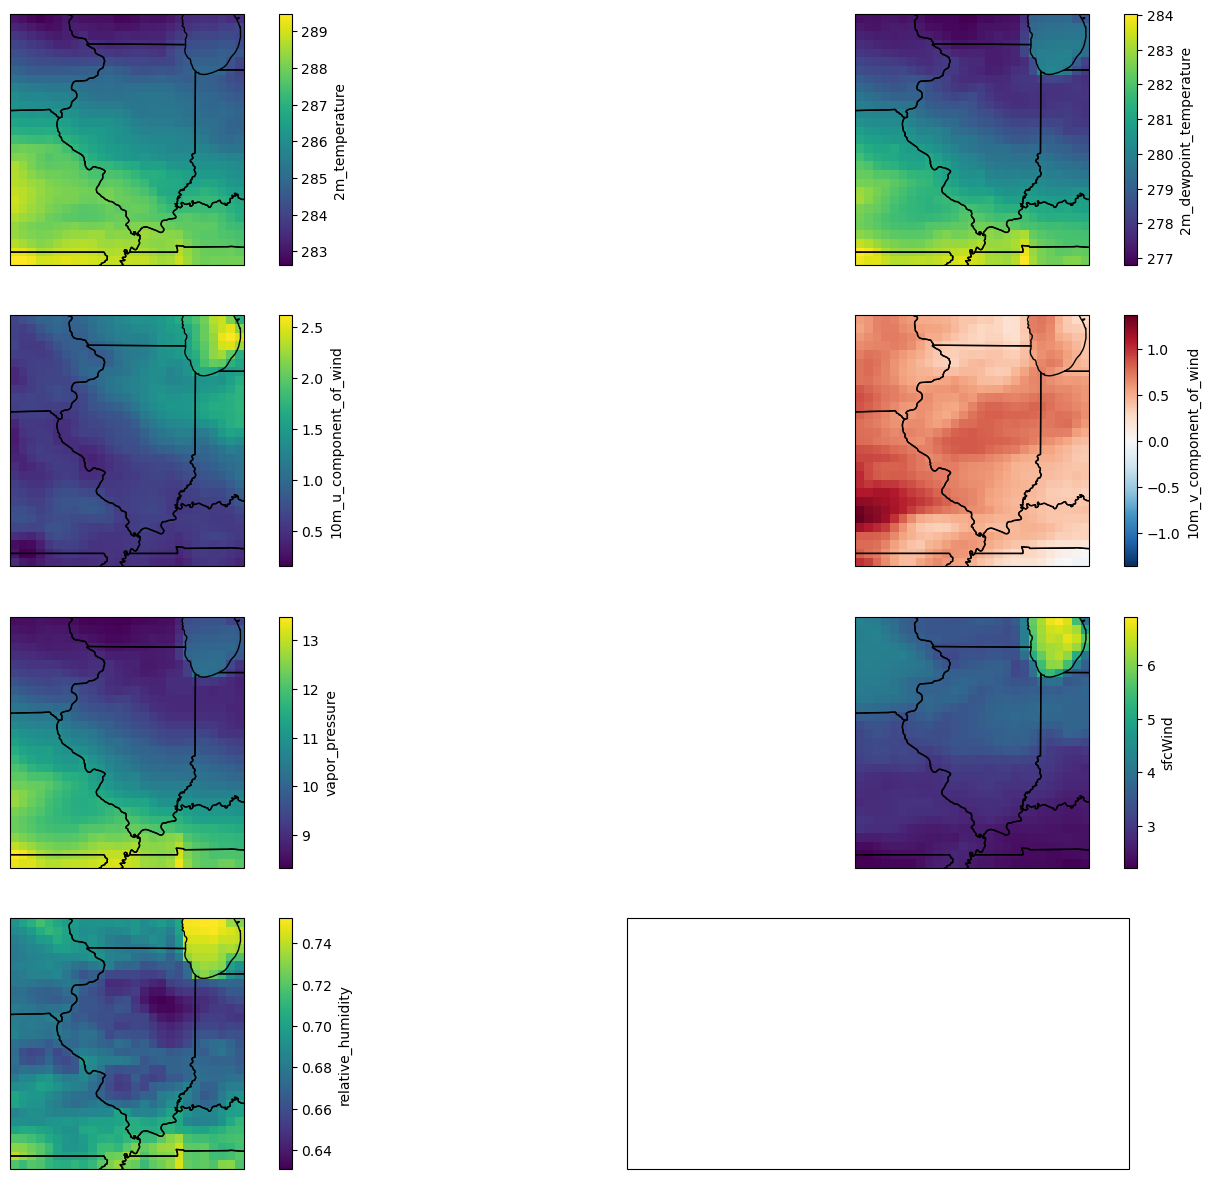

In [6]:
plt.rcParams['figure.figsize'] = [20, 15]
fig, ax = plt.subplots(4,2, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
ax = ax.flatten()

for var in range(0,7):
    list_var = list(test_dset.keys())
    test_dset[list_var[var]].mean('time').plot.pcolormesh(x='lon', y='lat', ax=ax[var], transform=ccrs.PlateCarree(),)
    ax[var].add_feature(cfeature.STATES)

In [2]:
from ERA5.ERA5_processor import era5_processing

test_dset = era5_processing('relative_humidity', 2014, 2015, 'analysis_ready')
test_dset

Done
<xarray.Dataset> Size: 110MB
Dimensions:                  (time: 17520, lat: 29, lon: 27)
Coordinates:
  * lat                      (lat) float32 116B 43.25 43.0 42.75 ... 36.5 36.25
  * lon                      (lon) float32 108B 267.2 267.5 ... 273.5 273.8
  * time                     (time) datetime64[ns] 140kB 2014-01-01 ... 2015-...
Data variables:
    2m_temperature           (time, lat, lon) float32 55MB dask.array<chunksize=(48, 29, 27), meta=np.ndarray>
    2m_dewpoint_temperature  (time, lat, lon) float32 55MB dask.array<chunksize=(48, 29, 27), meta=np.ndarray>
Attributes:
    valid_time_start:       1940-01-01
    last_updated:           2025-05-21 02:34:14.468750+00:00
    valid_time_stop:        2025-02-28
    valid_time_stop_era5t:  2025-05-15


<xarray.DataArray (time: 17520, lat: 29, lon: 27)> Size: 55MB
dask.array<truediv, shape=(17520, 29, 27), dtype=float32, chunksize=(48, 29, 27), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 116B 43.25 43.0 42.75 42.5 ... 37.0 36.75 36.5 36.25
  * lon      (lon) float32 108B 267.2 267.5 267.8 268.0 ... 273.2 273.5 273.8
  * time     (time) datetime64[ns] 140kB 2014-01-01 ... 2015-12-31T23:00:00

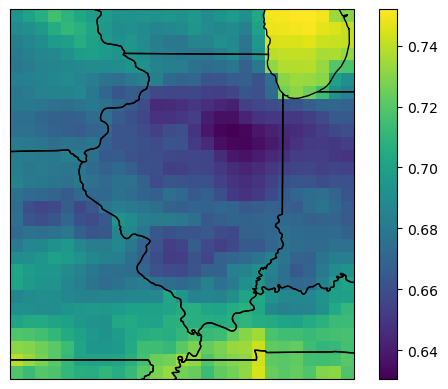

In [8]:
dset_mean = test_dset.sel(time=slice('2014-10-20', '2014-10-30')).mean('time')

fig, ax = plt.subplots(1,1, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})

dset_mean.plot.pcolormesh(x='lon', y='lat', ax=ax, transform=ccrs.PlateCarree(),)
ax.add_feature(cfeature.STATES)